In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv('CC GENERAL.csv')

In [2]:
df.info()
df.describe()
df.isnull().sum()

df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [3]:
df_cluster = df.drop('CUST_ID', axis=1)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# **Finding the ideal number of clusters**

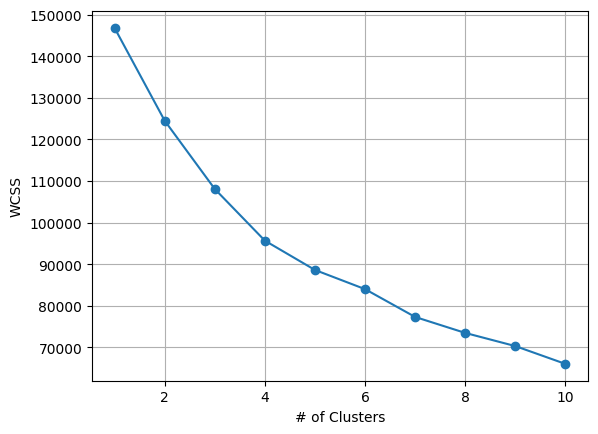

In [29]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

We are trying to find this ideal number through the Elbow Method.

Here we can infer that the ideal value would be **4 clusters**, where the "elbow fold" is.

# **Breaking down and understandig the clusters**

In [5]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_scaled)
df['Cluster'] = kmeans.labels_

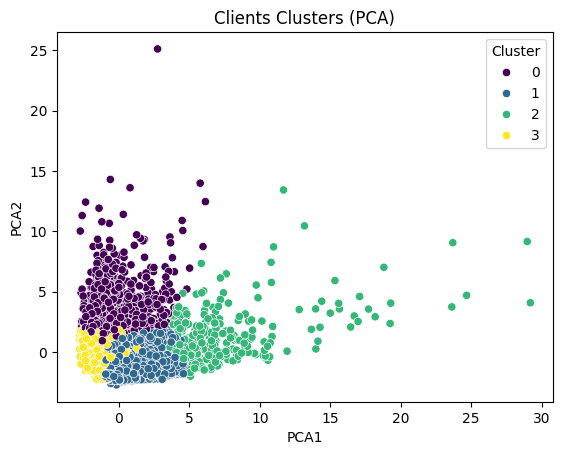

In [30]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df['PCA1'] = principal_components[:,0]
df['PCA2'] = principal_components[:,1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('Clients Clusters (PCA)')
plt.show()

Each color represents a cluster, and through this graph we can see who looks like who.

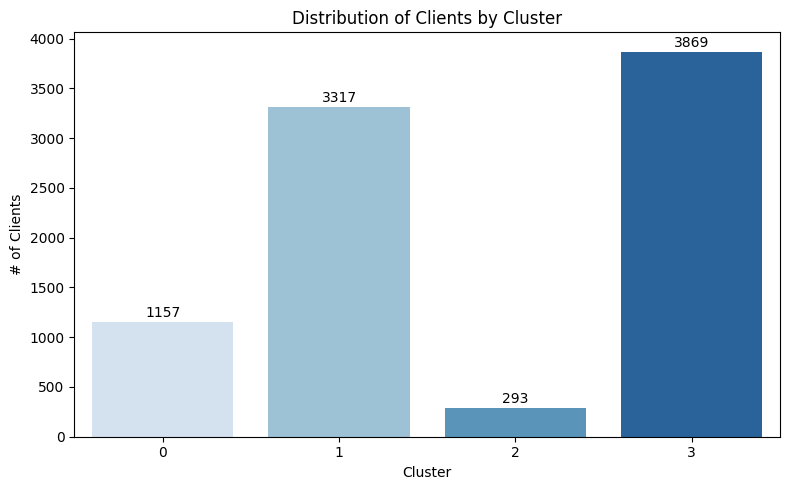

In [37]:
cluster_counts = df['Cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    x=cluster_counts.index,
    y=cluster_counts.values,
    hue=cluster_counts.index,
    palette=sns.color_palette("Blues", n_colors=len(cluster_counts)),
    legend=False
)
plt.title('Distribution of Clients by Cluster')
plt.xlabel('Cluster')
plt.ylabel('# of Clients')
plt.xticks(rotation=0)

for i, v in enumerate(cluster_counts.values):
    plt.text(i, v + 50, str(v), ha='center')

plt.tight_layout()
plt.show()

Cluster 3 is our largest group. It represents about 45% of all customers

Cluster 1 represents about 38%.
Cluster 0 aound 13%.

And Cluster 2 is our smallest group, with only about 4%.

In [52]:
df.groupby('Cluster') \
  .mean(numeric_only=True) \
  .T \
  .style \
  .background_gradient(cmap="Blues") \
  .format("{:.2f}")

Cluster,0,1,2,3
BALANCE,4652.10,970.42,3941.95,1052.43
BALANCE_FREQUENCY,0.97,0.95,0.99,0.82
PURCHASES,511.05,1374.13,8980.11,277.90
ONEOFF_PURCHASES,324.08,687.24,5968.52,212.10
INSTALLMENTS_PURCHASES,187.05,687.08,3013.64,66.15
CASH_ADVANCE,4589.61,223.01,764.36,597.52
PURCHASES_FREQUENCY,0.29,0.89,0.95,0.18
ONEOFF_PURCHASES_FREQUENCY,0.14,0.32,0.73,0.09
PURCHASES_INSTALLMENTS_FREQUENCY,0.19,0.72,0.79,0.09
CASH_ADVANCE_FREQUENCY,0.49,0.04,0.08,0.12


**Cluster 0 – "Moderate Spenders, Cash Advance Dependent"**
*   Low spending (few transactions, low average value)
*   Heavy use of cash advances
*   Rarely pay full statement balance (PRC_FULL_PAYMENT ≈ 4%)

**Cluster 1 – "Active and Consistent Shoppers"**
*   High overall spending
*   Balanced use of installments and one-time purchases
*   Frequent payments with a good full payment rate (PRC_FULL_PAYMENT ≈ 27%)

**Cluster 2 – "Super Shoppers"**
*   Very high spending volume (PURCHASES > 8,000)
*   High ticket size and near-max purchase frequency (0.94+)
*   High credit limit

**Cluster 3 – "Inactive or Low-Usage Customers"**
*   Few purchases and limited card usage
*   Low balance and low credit limit
*   Low payments

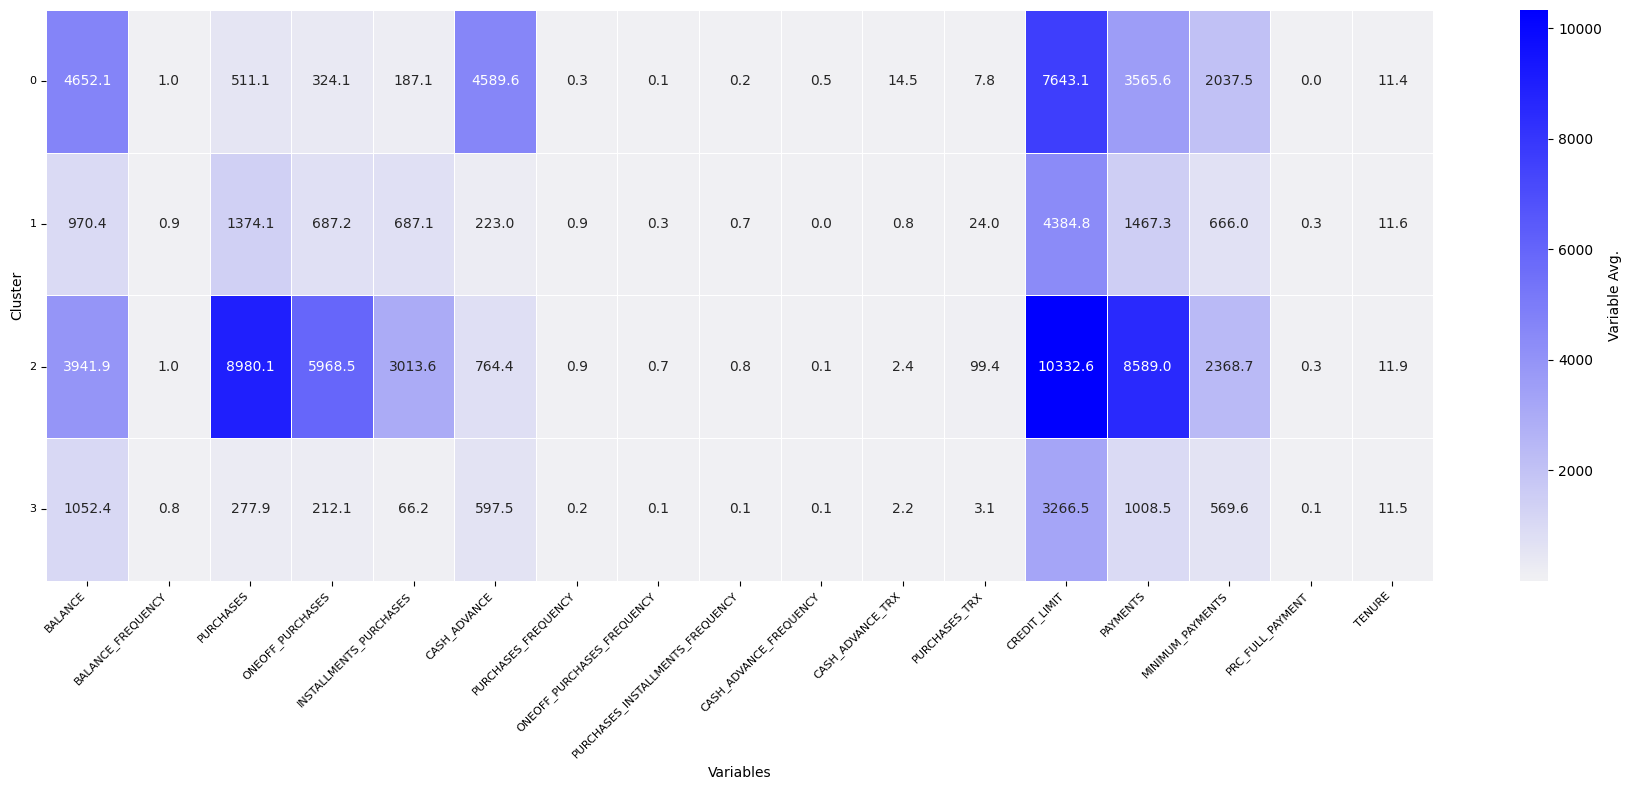

In [40]:
numeric_cols = df.select_dtypes(include='number').columns.drop(['Cluster', 'PCA1', 'PCA2'])
cluster_means = df.groupby('Cluster')[numeric_cols].mean().round(2)

blue_cmap = sns.light_palette("blue", as_cmap=True)

plt.figure(figsize=(18, 8))
sns.heatmap(
    cluster_means,
    annot=True,
    fmt=".1f",
    cmap=blue_cmap,
    linewidths=0.5,
    cbar_kws={'label': 'Variable Avg.'},
)

plt.xlabel('Variables', fontsize=10)
plt.ylabel('Cluster', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.show()